# Table Type Classifier Training 

This notebook shows how to train a table type classifier on the **SegmentedTables** dataset. You can download the model weights at https://github.com/paperswithcode/axcell/releases/download/v1.0/models.tar.xz.

In [1]:
from axcell.helpers.datasets import read_tables_annotations
from pathlib import Path

V1_URL = 'https://github.com/paperswithcode/axcell/releases/download/v1.0/'
SEGMENTED_TABLES_URL = V1_URL + 'segmented-tables.json.xz'

segmented_tables_annotations = read_tables_annotations(SEGMENTED_TABLES_URL)

In [2]:
from axcell.data.paper_collection import PaperCollection

SEGMENTED_TABLES_PAPERS = Path('/mnt/efs/pwc/data/arxiv/sources/segmented-tables/papers')
pc = PaperCollection.from_files(SEGMENTED_TABLES_PAPERS, annotations=segmented_tables_annotations.to_dict(orient='record'))

We convert papers and annotations into a dataframe with features: table caption, content of table headers, and headlines of sections referencing the table. We later specify in ULMFiTTableTypeExperiment which of these featues to use.

In [3]:
import pandas as pd
import re
from collections import OrderedDict
from fastai.text import *

anchor_re = re.compile(r'^xxanchor-\S* ')

# find headlines (possibly with duplicates) of sections
# referencing a given table in paper's text
def find_sections(paper, table):
    anchor = table.figure_id
    if anchor is None:
        return []
    anchor = 'xxref-' + anchor.replace('.', '')
    sections = [anchor_re.sub('', fragment.header) for fragment in paper.text.fragments if anchor in fragment.text]
    sections = [section for section in sections if section]
    return sections


def get_tabletype_features(papers, deduplicate=True):
    records = []
    dedup_fn = (lambda x: x) if not deduplicate else lambda x: list(OrderedDict.fromkeys(x))
    for paper in sorted(papers, key=lambda p: p.paper_id):
        for table in paper.tables:
            tags = table.gold_tags.split()
            record = dict(
                id=f'{paper.paper_id}/{table.name}',
                fold=paper.gold_tags,
                caption=table.caption or '',
                sota='leaderboard' in tags,
                ablation='ablation' in tags,
                sections=' ; '.join(dedup_fn(find_sections(paper, table))),
                row0=' ; '.join(dedup_fn(table.matrix.iloc[:,0])),
                col0=' ; '.join(dedup_fn(table.matrix.iloc[0,:]))
            )
            records.append(record)
    return pd.DataFrame(records)


# make sure the training dataframe is batch_size aligned
def align_df(df, batch_size):
    aligned_len = ( len(df) // batch_size ) * batch_size
    return df.iloc[:aligned_len]


def dataframes_to_databunch(sigmoid, base_path, train_df, valid_df, test_df, batch_size, processor):
    columns = []
    if sigmoid:
        label_cols = [x for x in ["sota", "ablation", "irrelevant"] if x in train_df.columns]
    else:
        label_cols = ["class"]
    text_cols = [x for x in ["caption", "sections", "row0", "col0"] if x in train_df.columns]
    columns = label_cols + text_cols
    
    train_df, valid_df, test_df = train_df[columns], valid_df[columns], test_df[columns]
    
    if len(label_cols) > 1:
        classes = label_cols
    else:
        classes = None
    train_tl = TextList.from_df(train_df, base_path, cols=text_cols, processor=processor)
    valid_tl = TextList.from_df(valid_df, base_path, cols=text_cols, processor=processor)
    test_tl  = TextList.from_df(test_df,  base_path, cols=text_cols, processor=processor)
    
    src = ItemLists(base_path, train_tl, valid_tl)\
        .label_from_df(cols=label_cols, classes=classes)
    src.add_test(test_tl)
    
    data_clas = src.databunch(bs=batch_size)
    return data_clas


def get_databunch(experiment, df, processor):
    df = experiment.transform_df(df)
    is_test = df.fold == experiment.test_split
    is_valid = df.fold == experiment.valid_split
    test_df = df[is_test]
    valid_df = df[is_valid]
    train_df = df[(~is_test) & (~is_valid)]
    train_df = align_df(train_df, experiment.BS)
    data_clas = dataframes_to_databunch(
        experiment.sigmoid, BASE_DIR, train_df, valid_df,
        test_df, experiment.BS, processor
    )
    
    return train_df, valid_df, test_df, data_clas

In [4]:
from axcell.models.structure.experiment import experiments_grid
from axcell.models.structure.ulmfit_experiment import ULMFiTTableTypeExperiment

EXPERIMENTS_DIR = './experiments/tabletype'
BASE_DIR = Path('./models')

processor = processor = SPProcessor(
    sp_model=BASE_DIR / 'tmp' / 'spm.model',
    sp_vocab=BASE_DIR / 'tmp' / 'spm.vocab',
    mark_fields=True
)

# parameters common for all experiments
base_experiment = ULMFiTTableTypeExperiment(
    dataset="segmented-tables",
    drop_mult=1.0,
    fp16=False,
    test_split='img_class',
    valid_split='speech_rec',
    pretrained_lm='lm',
    schedule=(
        (1, 1e-2),   # (a,b) -> fit_one_cyclce(a, b)
        (1, 5e-3/2., 5e-3),  # (a, b) -> freeze_to(-2); fit_one_cycle(a, b)
        (10, 1e-2 / (2.6 ** 4), 1e-3)  # (a, b) -> unfreeze(); fit_one_cyccle(a, b)
    ),
    sigmoid=False,
    BS=128,
    dedup_seqs=True,
    caption=True,
    first_row=False,
    first_column=False,
    referencing_sections=False
)

In [5]:
experiments = list(experiments_grid(
    base_experiment,
    seed=[1234, 6671347, 531609, 999999, 135792468]
))

In [7]:
import gc

EXPERIMENTS_DIR = './experiments/tabletype'
df_dedup = get_tabletype_features(pc, deduplicate=True)
df_nodedup = get_tabletype_features(pc, deduplicate=False)

# folds = sorted(df_dedup.fold.unique())
# folds.remove(base_experiment.test_split)

for i in range(len(experiments)):
    experiment = experiments[i]
    df = df_dedup if experiment.dedup_seqs else df_nodedup

    train_df, valid_df, test_df, data_clas = get_databunch(experiment, df, processor)
    print(f'Running experiment {i+1} / {len(experiments)}')
    model = experiment.get_trained_model(data_clas)
    experiment.evaluate(model, train_df, valid_df, test_df)
    experiment.save(EXPERIMENTS_DIR)

#     experiments[i] = None
#     experiment = None
#     gc.collect()

In [16]:
edf = ULMFiTTableTypeExperiment.experiments_to_df(experiments).reset_index()

In [17]:
edf[['valid_accuracy', 'valid_bin_accuracy', 'test_accuracy', 'test_bin_accuracy']]

,valid_accuracy,valid_bin_accuracy,test_accuracy,test_bin_accuracy
0,0.572368,0.763158,0.703226,0.819355
1,0.625000,0.809211,0.748387,0.858065
2,0.578947,0.750000,0.716129,0.825806
3,0.592105,0.769737,0.748387,0.858065
4,0.565789,0.703947,0.722581,0.858065


In [23]:
best_idx = edf.valid_bin_accuracy.idxmax()
best = experiments[best_idx]

train dataset
 * accuracy: 0.751
 * μ-precision: 0.700
 * μ-recall: 0.950
valid dataset
 * accuracy: 0.625
 * μ-precision: 0.643
 * μ-recall: 0.741
test dataset
 * accuracy: 0.748
 * μ-precision: 0.726
 * μ-recall: 0.924


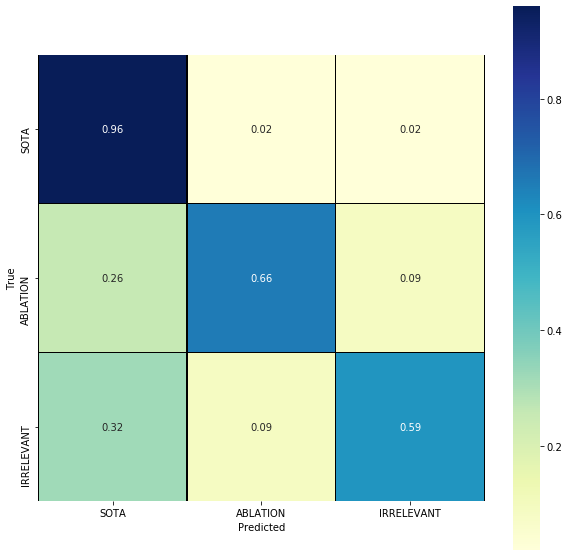

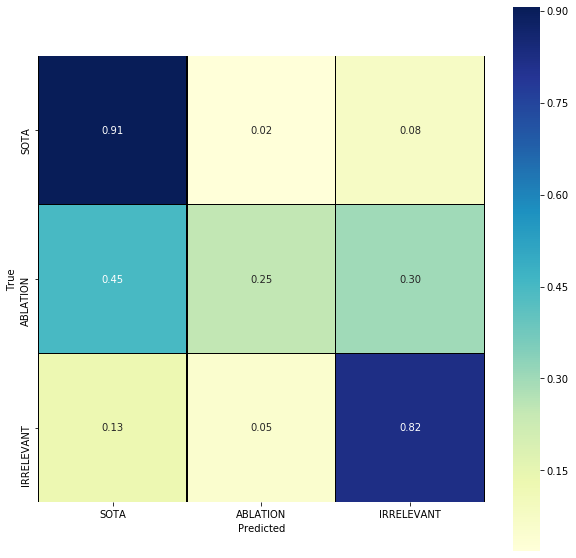

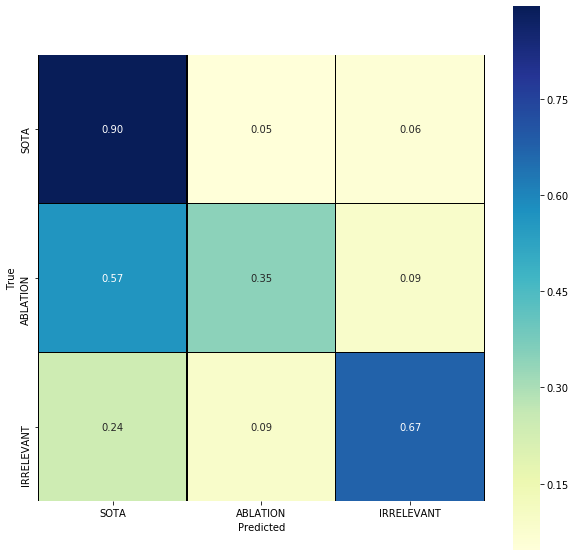

In [24]:
best.show_results()

In [ ]:
best._model.export('table-type-classifier')